## Análise De Dados Drun

A intenção dessa análise simples é explorar os dados antes de começar a construção do dashboard, pois assim tiro minhas dúvidas e faço um dashboard que seja realmente utilizável e objetivo.

In [3]:
# Importação das Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from google.oauth2 import service_account

<h4> Extraindo os dados diretamento do Bigquery </h4> 

<p> Consulta no database do GBQ </p>

In [4]:
query = ''' 
    SELECT * 
    FROM `appoutsider.appoutsider.table_analysis`;
'''

<p> Configurações de credênciais para conectar com API do Google </p>

In [5]:
key_file_path = "../GBQ.json"

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform'
]

credentials = service_account.Credentials.from_service_account_file(
    key_file_path, scopes=['https://www.googleapis.com/auth/cloud-platform']
)

<h4>Análise Exploratória</h4>

<p> Extração de dados </p>

In [6]:
df = pd.read_gbq(credentials=credentials, query=query)

In [7]:
df.head()

,VendorID,lpep_pickup_datetime,pickup_period,lpep_dropoff_datetime,dropoff_period,passenger_count,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough,payment_description,ratecode_description,trip_distance,tip_amount,tolls_amount,fare_amount,total_amount
0,1,2021-09-02 10:22:07+00:00,AM,2021-09-02 10:51:34+00:00,AM,5,Corona,Queens,JFK Airport,Queens,Cash,Negotiated fare,10.3,0.0,0.0,0.0,0.0
1,1,2021-09-12 06:29:58+00:00,PM,2021-09-12 06:30:18+00:00,PM,5,Corona,Queens,Corona,Queens,No charge,Negotiated fare,0.2,0.0,0.0,0.0,0.0
2,1,2021-06-25 12:16:29+00:00,PM,2021-06-25 12:57:14+00:00,PM,5,Corona,Queens,North Corona,Queens,Cash,Negotiated fare,7.9,0.0,0.0,0.0,0.0
3,1,2021-10-14 07:44:25+00:00,PM,2021-10-14 08:15:10+00:00,PM,1,Corona,Queens,Corona,Queens,Credit card,Standard rate,0.0,0.0,0.0,0.0,0.0
4,1,2021-09-01 06:57:12+00:00,PM,2021-09-01 06:57:56+00:00,PM,5,Corona,Queens,Corona,Queens,No charge,Negotiated fare,0.3,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<p>Convertendo columns de datas de object para datetime</p>

In [9]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

In [10]:
df['month_pickup'] = df['lpep_pickup_datetime'].dt.month
df['month_dropoff'] = df['lpep_dropoff_datetime'].dt.month

In [11]:
df = df[(df['pickup_borough'] != "EWR") & (df['dropoff_borough'] != "EWR")]

<p> Total de viagens por destrito </p>

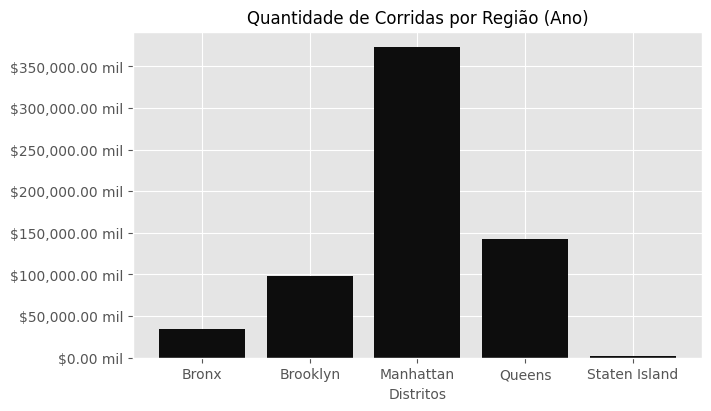

In [59]:
def format_currency(value, tick_number):
    return f'${value:,.2f} mil'


borough_total_trips = df.groupby("pickup_borough").agg({"total_amount" : "count"})
borough_total_trips.sort_values(by=['total_amount'], ascending=False)

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)

plt.style.use('ggplot')

borough = [x for x in borough_total_trips.index.values]
drivers = [x for x in borough_total_trips['total_amount'].values]

ax.bar(borough, drivers, color="#F44336")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_currency))

ax.set_title('Quantidade de Corridas por Região (Ano)', fontdict={'size' : 12})
plt.xlabel('Distritos', fontdict={'size' : 10})
plt.show()

<p>Período de mais movimentação de usuários no APP</p>

In [13]:
period_trips = df.groupby(['dropoff_period']).agg({"total_amount" : "count"})

period_trips

,total_amount
dropoff_period,
AM,218724
PM,431027


<p> Método de pagamento mais usado no APP </p>

In [14]:
payment_type = df.groupby(['payment_description']).agg({'total_amount' : 'count'})

payment_type.sort_values(by=['total_amount'], ascending=False)

,total_amount
payment_description,
Credit card,387102
Cash,257728
No charge,3839
Dispute,1075
Unknown,7


In [15]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'pickup_period',
       'lpep_dropoff_datetime', 'dropoff_period', 'passenger_count',
       'pickup_zone', 'pickup_borough', 'dropoff_zone', 'dropoff_borough',
       'payment_description', 'ratecode_description', 'trip_distance',
       'tip_amount', 'tolls_amount', 'fare_amount', 'total_amount',
       'month_pickup', 'month_dropoff'],
      dtype='object')

<p> Novo copy para manipular os dados para ánalise</p>

In [ ]:
analysis_per_month = df[['month_pickup', 'month_dropoff', 'ratecode_description', 'pickup_zone','pickup_borough', 'dropoff_zone', 'dropoff_borough','total_amount']]

month_map = {
    1: "Jan", 2: "Fev", 3: "Mar", 4: "Abr", 5: "Mai", 6: "Jun", 7: "Jul", 8: "Ago", 9: "Set", 10: "Out", 11: "Nov", 12: "Dez"
}

analysis_per_month['month_description_pickup'] = analysis_per_month['month_pickup'].map(month_map)
analysis_per_month['month_description_dropoff'] = analysis_per_month['month_dropoff'].map(month_map)

analysis_per_month.head()

<p>Ordenando os dataframes por mês</p>

In [17]:
order_of_months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

profit_per_month = analysis_per_month.groupby(['month_description_dropoff']).agg({'total_amount' : 'sum'})
profit_per_month = profit_per_month.reindex(order_of_months, level=0)

avg_per_month = analysis_per_month.groupby(['month_description_dropoff']).agg({'total_amount' : np.mean})
avg_per_month = avg_per_month.reindex(order_of_months, level=0)

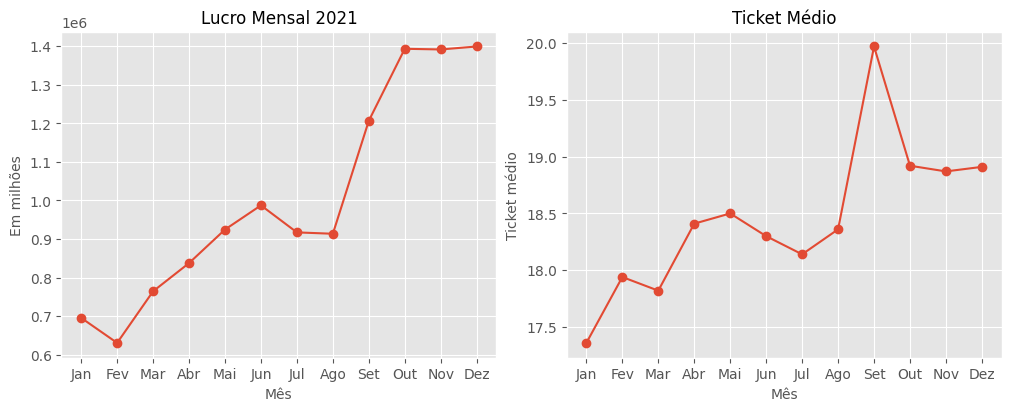

In [18]:
months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
total_per_month = [np.round(x, 2) for x in profit_per_month['total_amount'].values]
avg_values_per_month = [np.round(x, 2) for x in avg_per_month['total_amount'].values]


fig, axs = plt.subplots(nrows=1, ncols= 2, figsize=(10, 4), constrained_layout=True)

# Gráfico no primeiro subplot
axs[0].plot(months, total_per_month, marker="o")
axs[0].set_title('Lucro Mensal 2021', fontdict={'size' : 12})
axs[0].set_xlabel('Mês', fontdict={'size' : 10})
axs[0].set_ylabel('Em milhões', fontdict={'size' : 10})

# Gráfico no segundo subplot
axs[1].plot(months, avg_values_per_month, marker="o")
axs[1].set_title('Ticket Médio', fontdict={'size' : 12})
axs[1].set_xlabel('Mês', fontdict={'size' : 10})
axs[1].set_ylabel('Ticket médio', fontdict={'size' : 10})

plt.show()

<p> Top 5 lugas mais escolhidas para desemparque em Manhattan</p>

In [19]:
zones_in_manhattan = analysis_per_month[(analysis_per_month['pickup_borough'] == 'Manhattan') & (analysis_per_month['dropoff_borough'] == 'Manhattan')]

zones_in_manhattan.groupby('dropoff_zone').agg({'total_amount' : 'count'}).sort_values(by=['total_amount'], ascending=False).head()

,total_amount
dropoff_zone,
East Harlem North,36526
East Harlem South,31044
Central Harlem North,28034
Central Harlem,27228
Upper East Side North,19133


<p>Nassau e Westchester são taxas adicionais para quando a viagem passa dos limites de Nova Iorque</p>

In [20]:
ratecode_trend = analysis_per_month.groupby(['ratecode_description']).agg({'total_amount' : 'count'})
ratecode_trend = ratecode_trend.sort_values(by=['total_amount'], ascending=False)

ratecode_trend

,total_amount
ratecode_description,
Standard rate,623985
Negotiated fare,23752
JFK,1757
Newark,179
Nassau or Westchester,78


<p>Total de corridas por mês</p>

In [57]:


total_trips_per_month = analysis_per_month.groupby(['month_description_dropoff']).agg({'total_amount' : 'count'})

total_trips_per_month = total_trips_per_month.reindex(order_of_months, level=0)

total_trips_per_month

,total_amount
month_description_dropoff,
Jan,40078
Fev,35156
Mar,42901
Abr,45513
Mai,49984
Jun,53945
Jul,50564
Ago,49755
Set,60441


<p>Dezembro foi o mês com mais viagens concluídas no APP</p>

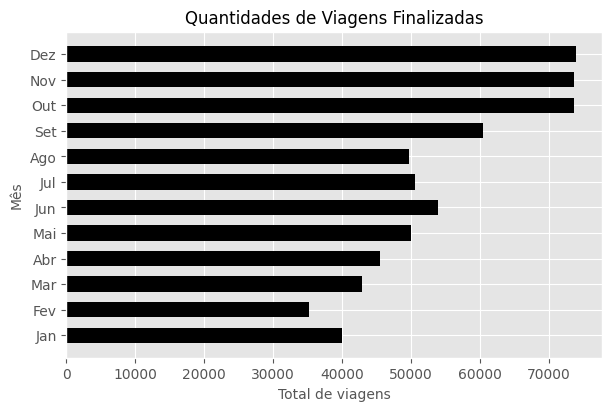

In [55]:
fig, ax = plt.subplots(figsize = (6, 4), constrained_layout=True)

months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
number_trip_per_month = [x for x in total_trips_per_month['total_amount'].values]

ax.barh(months, number_trip_per_month, height=0.6, color="#F44336")

plt.title("Quantidades de Viagens Finalizadas", fontdict={'size' : 12})
plt.ylabel("Mês", fontdict={'size' : 10})
plt.xlabel("Total de viagens", fontdict={'size' : 10})
plt.show()